
# Progressive Clean-Clean Entity Resolution Tutorial

In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. Clean-Clean ER in the link discovery/deduplication between two sets of entities.


Dataset: __Abt-Buy dataset__ (D1)

The Abt-Buy dataset for entity resolution derives from the online retailers Abt.com and Buy.com. The dataset contains 1076 entities from abt.com and 1076 entities from buy.com as well as a gold standard (perfect mapping) with 1076 matching record pairs between the two data sources. The common attributes between the two data sources are: product name, product description and product price.

## How to install?

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [1]:
!pip install pyjedai -U

In [2]:
!pip show pyjedai

Name: pyjedai
Version: 0.1.3
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>, Manolis Koubarakis <koubarak@di.uoa.gr>
License: Apache Software License 2.0
Location: c:\users\nikol\anaconda3\envs\d31\lib\site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, plotly, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


Imports

In [3]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

In [4]:
import pyjedai
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Reading

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 


In [5]:
from pyjedai.datamodel import Data
from pyjedai.evaluation import Evaluation

In [7]:
d1 = pd.read_csv("./../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False)
d2 = pd.read_csv("./../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False)
gt = pd.read_csv("./../data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(dataset_1=d1,
            id_column_name_1='id',
            dataset_2=d2,
            id_column_name_2='id',
            ground_truth=gt)

pyJedAI offers also dataset analysis methods (more will be developed)

In [8]:
data.print_specs()

------------------------- Data -------------------------
Type of Entity Resolution:  Clean-Clean
Dataset-1:
	Number of entities:  1076
	Number of NaN values:  0
	Attributes: 
		 ['name', 'description', 'price']
Dataset-2:
	Number of entities:  1076
	Number of NaN values:  0
	Attributes: 
		 ['name', 'description', 'price']

Total number of entities:  2152
Number of matching pairs in ground-truth:  1076
-------------------------------------------------------- 



In [9]:
data.dataset_1.head(5)

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158


In [10]:
data.dataset_2.head(5)

,id,name,description,price
0,0,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,
1,1,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,
2,2,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,
3,3,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,
4,4,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,


In [11]:
data.ground_truth.head(3)

,D1,D2
0,206,216
1,60,46
2,182,160


### Data cleaning step (optional)

pyJedAI offers 4 types of text cleaning/processing. 

- Stopwords removal
- Punctuation removal
- Numbers removal
- Unicodes removal

In [12]:
data.clean_dataset(remove_stopwords = False, 
                   remove_punctuation = False, 
                   remove_numbers = False,
                   remove_unicodes = False)

# Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking
- Sorted Neighborhood
- Extended Sorted Neighborhood
- Q-Grams Blocking
- Extended Q-Grams Blocking
- Suffix Arrays Blocking
- Extended Suffix Arrays Blocking

In [13]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

/home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
bb = StandardBlocking()
blocks = bb.build_blocks(data, attributes_1=['name', 'description'], attributes_2=['name', 'description'])

Standard Blocking: 100%|██████████| 2152/2152 [00:00<00:00, 21279.99it/s]


In [15]:
bb.report()

Method name: Standard Blocking
Method info: Creates one block for every token in the attribute values of at least two entities.
Parameters: Parameter-Free method
Attributes from D1:
	name, description
Attributes from D2:
	name, description
Runtime: 0.1018 seconds


In [16]:
_ = bb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.1018 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.12% 
	Recall:        99.81%
	F1-score:       0.25%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1074
	False positives: 874536
	True negatives: 1156698
	False negatives: 2
	Total comparisons: 875610
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Block Purging

__Optional step__

Discards the blocks exceeding a certain number of comparisons. 


In [17]:
from pyjedai.block_cleaning import BlockPurging

In [18]:
bp = BlockPurging()
cleaned_blocks = bp.process(blocks, data, tqdm_disable=False)

Block Purging: 100%|██████████| 4096/4096 [00:00<00:00, 838778.89it/s]


In [19]:
bp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 11845.0
Runtime: 0.0060 seconds


In [20]:
_ = bp.evaluate(cleaned_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 11845.0
Runtime: 0.0060 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.26% 
	Recall:        99.81%
	F1-score:       0.52%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Block Cleaning

___Optional step___

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

In [21]:
from pyjedai.block_cleaning import BlockFiltering

In [22]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(cleaned_blocks, data, tqdm_disable=False)

Block Filtering: 100%|██████████| 3/3 [00:00<00:00, 94.76it/s]


In [23]:
bf.evaluate(filtered_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Filtering
***************************************************************************************************************************
Method name: Block Filtering
Parameters: 
	Ratio: 0.8
Runtime: 0.0326 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.68% 
	Recall:        99.26%
	F1-score:       1.35%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.6797958066528331,
 'Recall %': 99.25650557620817,
 'F1 %': 1.3503432754674995,
 'True Positives': 1068,
 'False Positives': 156038,
 'True Negatives': 1156692,
 'False Negatives': 8}

## Progressive Entity Resolution

___Scheduling + Emission + Matching___

Progressive Entity Resolution (PER) consists of the above three stages. Specifically:

**1. Scheduling -** This step is similar to Comparison Cleaning. We extract a subset of the original fully connected dataset in which each entity could be a duplicate candidate for any other entity. This is done by deriving neighborhoods for each entity, which contain its duplicate candidates.

**2. Emission -** We iterate over the previously derived neighborhoods following a wide variety of algorithms (BFS, DFS, Hybrid etc.) and we extract the final candidate pairs. The number of emissions is limited by our *budget*.

**3. Matching -** The candidate pairs are evaluated on the premise of being true duplicates. PER methods allow for the calculation of cumulative recall and as a result give us the possibility of deriving AUCs and plotting ROCs for different budget limitations.

The following workflows are currently supported:


* **NN workflows -**
Progressive Vector Based BB (EmbeddingsNNBPM)

* **Join workflows -**
Base/Vector Based Progressive TopKJoin (TopKJoinPM)

* **MB (Hash Based) workflows -**
Progressive CEP (GlobalTopPM), 
Progressive CNP (LocalTopPM)

* **Sorted Neighborhood workflows -**
Global Progressive Sorted Neighborhood (GlobalPSNM), 
Local Progressive Sorted Neighborhood (LocalPSNM)

* **Scheduling workflows -**
Progressive Entity Scheduling (PESM)

In [24]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM,
    TopKJoinPM
)

In [25]:
# Maximum number of candidate pair emissions that can be parsed to matching
BUDGET=10000
# Emission Algorithm (DFS/BFS/HB/TOP)
ALGORITHM="BFS"
# Identification Context - defines which dataset is the source and target one (inorder/reverse/bilateral)
# Non-inorder indexing makes sense only in the context of NN and Join PER workflows
# The other ones conduct entity identification in both dataset directions
INDEXING="inorder"

### NN PER (Vector Based)

In [ ]:
ennbpm = EmbeddingsNNBPM(language_model="sminilm",
                         number_of_nearest_neighbors=10,
                         similarity_search="faiss",
                         similarity_function="euclidean",
                         similarity_threshold=0.0
                        )

# NN PER workflows don't require blocks in order to define neighborhoods
# Entities are vectorized and similarity function is applied (e.x. faiss)
# In an attempt to cluster similar entities into neighborhoods
ennbpm_candidates = ennbpm.predict(data=data,
                                   blocks=None,
                                   budget=BUDGET,
                                   algorithm=ALGORITHM,
                                   indexing=INDEXING
                                   )



### JN PER (Join)

In [27]:
tkjpm = TopKJoinPM(number_of_nearest_neighbors=10,
                   similarity_function='cosine',
                   tokenizer='char_tokenizer',
                   weighting_scheme='tfidf',
                   qgram=5,
                   similarity_threshold=0.0
                   )

tkjpm_candidates = tkjpm.predict(data=data,
                                 blocks=blocks,
                                 budget=BUDGET,
                                 algorithm=ALGORITHM,
                                 indexing=INDEXING
                                )

Top-K Join Progressive Matching:   0%|          | 0/2048 [00:18<?, ?it/s]


### MB PER (Metablocking Based)

In [28]:
ltpm = LocalTopPM(weighting_scheme="SN-CBS",
                   number_of_nearest_neighbors=10,
                   similarity_threshold=0.0
                   )

# Meta Blocking PER workflows allow for the purging and filtering of initial blocks
# To limit the search space
ltpm_candidates = ltpm.predict(data=data,
                  blocks=filtered_blocks,
                  budget=BUDGET,
                  algorithm=ALGORITHM,
                  indexing=INDEXING
                  )

Global Top Progressive Matching:   0%|          | 0/2022 [00:00<?, ?it/s]


### SN PER (Sorted Neighborhood)

In [29]:
gpsnm = GlobalPSNM(weighting_scheme='ACF',
                   window_size=10,
                   similarity_threshold=0.0)

gpsnm_candidates = gpsnm.predict(data=data,
                                 blocks=blocks,
                                 budget=BUDGET,
                                 algorithm=ALGORITHM,
                                 indexing=INDEXING
                                 )

Global Progressive Sorted Neighborhood Matching:   0%|          | 0/2048 [00:00<?, ?it/s]


## Evaluation (AUC & ROC)

An **ROC curve (receiver operating characteristic curve)** is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* Number of emitted candidate pairs (x Axis)
* Cumulative Recall (y Axis)

**AUC** stands for *"Area under the ROC Curve."* That is, AUC measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across the number of emitted pairs. It provides a visual and very intuitive tool to compare different PER workflows and spot patterns across the whole span of emissions.

In [30]:
matchers = [ennbpm, tkjpm, ltpm, gpsnm]

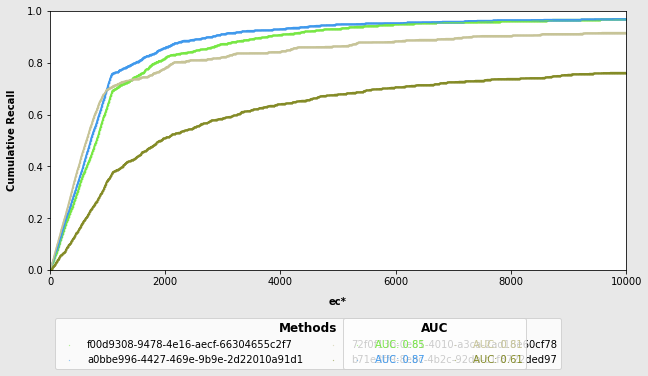

CPU times: user 183 ms, sys: 112 ms, total: 294 ms
Wall time: 176 ms


In [31]:
%%time
progressive_matchers_evaluator = Evaluation(data)
progressive_matchers_evaluator.evaluate_auc_roc(matchers = matchers, proportional = False)

In [32]:
print("NN WORKFLOW:")

print(f'Total Emissions: {ennbpm.get_total_emissions()}')
print(f'Cumulative Recall: {ennbpm.get_cumulative_recall()}')
print(f'Normalized AUC: {ennbpm.get_normalized_auc()}')

NN WORKFLOW:
Total Emissions: 10000
Cumulative Recall: 0.9684014869888475
Normalized AUC: 0.8500531917068019


In [33]:
print("JOIN WORKFLOW:")

print(f'Total Emissions: {tkjpm.get_total_emissions()}')
print(f'Cumulative Recall: {tkjpm.get_cumulative_recall()}')
print(f'Normalized AUC: {tkjpm.get_normalized_auc()}')

JOIN WORKFLOW:
Total Emissions: 10000
Cumulative Recall: 0.9693308550185874
Normalized AUC: 0.8705726081666761


In [34]:
print("MB WORKFLOW:")

print(f'Total Emissions: {ltpm.get_total_emissions()}')
print(f'Cumulative Recall: {ltpm.get_cumulative_recall()}')
print(f'Normalized AUC: {ltpm.get_normalized_auc()}')

MB WORKFLOW:
Total Emissions: 10000
Cumulative Recall: 0.9163568773234201
Normalized AUC: 0.8116456941666359


In [35]:
print("SN WORKFLOW:")

print(f'Total Emissions: {gpsnm.get_total_emissions()}')
print(f'Cumulative Recall: {gpsnm.get_cumulative_recall()}')
print(f'Normalized AUC: {gpsnm.get_normalized_auc()}')

SN WORKFLOW:
Total Emissions: 10000
Cumulative Recall: 0.7620817843866171
Normalized AUC: 0.6066398007039242


<hr>
<div align="right">
J. Maciejewski, K. Nikoletos,  G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>